<h1>Prediction of Coronavirus newCases in England</h1>

1. Retrieve latest data from GOV.UK publication using <a href='https://coronavirus.data.gov.uk/details/developers-guide'>coronavirus developer API</a>.
2. Preprocess the dataset into a Datetime indexed dataset for time-series analysis.
3. Problem definition: predict newCases for the next day (tomorrow). Regression task for a time-series dataset.
4. Exploratory data analysis (EDA) - checking time series properties.
5. Modeling: we applied a supervised learning algorithm (SVR). Baseline algorithm (comparison): just predict same as today's number.
6. Evaluation, Inference and Saving the model.
7. Model Deployment: we addressed this in another python file where a Flask application is created <a href='model_inference.py'>here</a>. 

<h3>1. Retrieve latest data from GOV.UK</h3>
We will be using Coronavirus developer API from GOV.UK applying filter and specifying the structure.<br/>
For more details, please refer to the developer API - link <a href='https://coronavirus.data.gov.uk/details/developers-guide'>here</a>.

In [1]:
# helpter_functions.py contain the function get_data
from helper_functions import get_data

# retrieving latest data from the Coronavirus developer API (GOV.UK)
# you can change the filters and structure below: refer to https://coronavirus.data.gov.uk/details/developers-guide
endpoint = (
        'https://api.coronavirus.data.gov.uk/v1/data?'
        'filters=areaType=nation;areaName=england&'
        'structure={"date":"date","newCases":"newCasesByPublishDate"}'
)
    
data = get_data(endpoint)
#print(data)

<h3>2. Preprocess the dataset into a Datetime indexed dataset</h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(data['data'])
print('The dataframe shape: ', df.shape)
print('Dataframe columns: ', df.columns)
df.head()

The dataframe shape:  (460, 2)
Dataframe columns:  Index(['date', 'newCases'], dtype='object')


,date,newCases
0,2021-04-06,1937
1,2021-04-05,2236
2,2021-04-04,1954
3,2021-04-03,2847
4,2021-04-02,2881


In [3]:
# converting to datetime index
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['date'], axis=1, inplace=True) # dropping the 'date' column: it is used as index now by the previous step
# the first entry is the latest one: this should reflect in time series, reversing the dataframe
df = df.reindex(index=df.index[::-1])
# the initial 5 rows/records after rearranging
df.head(5)

,newCases
date,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-07,0


In [4]:
# the latest 5 rows/records after rearranging
df.tail(5)

,newCases
date,
2021-04-02,2881
2021-04-03,2847
2021-04-04,1954
2021-04-05,2236
2021-04-06,1937


<h3>4. Exploratory Data Analysis (EDA)</h3>

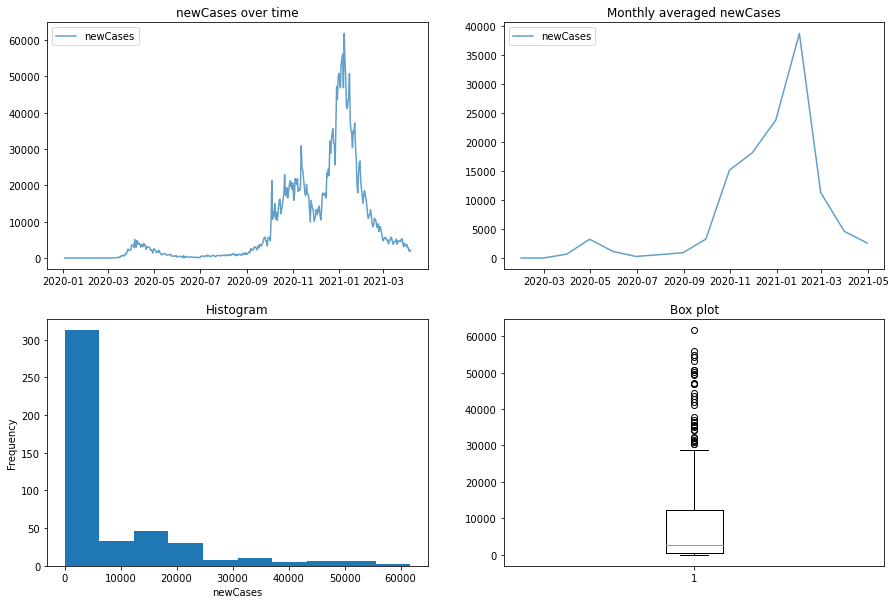

In [5]:
_ = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
_ = ax1.plot(df['newCases'], label='newCases', alpha=0.7)
_ = ax1.set_title('newCases over time')
_ = plt.legend()

ax2 = plt.subplot(222)
_ = ax2.plot(df.resample('M').mean(), label='newCases', alpha=0.7)
_ = ax2.set_title('Monthly averaged newCases')
_ = plt.legend()

ax3 = plt.subplot(223)
_ = ax3.hist(df['newCases'])
_ = ax3.set_title('Histogram')
_ = ax3.set_xlabel('newCases')
_ = ax3.set_ylabel('Frequency')

ax4 = plt.subplot(224)
_ = ax4.boxplot(df['newCases'])
_ = ax4.set_title('Box plot')

<h4>Stationary Properties (Trend, Seasonality and Residual)</h4>

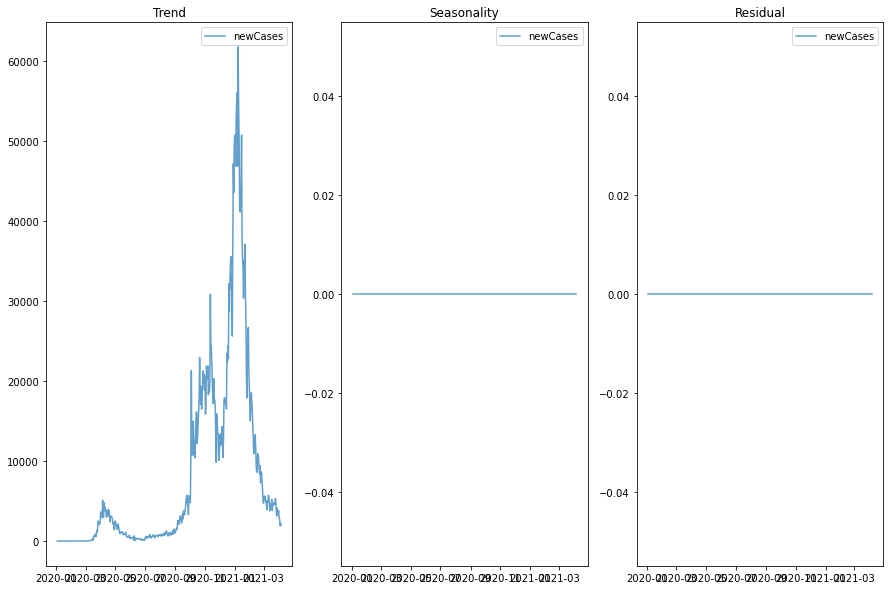

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df['newCases'], period=1)

_ = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(131)
_ = ax1.plot(res.trend, label='newCases', alpha=0.7)
_ = ax1.set_title('Trend')
_ = plt.legend()

ax2 = plt.subplot(132)
_ = ax2.plot(res.seasonal, label='newCases', alpha=0.7)
_ = ax2.set_title('Seasonality')
_ = plt.legend()

ax3 = plt.subplot(133)
_ = ax3.plot(res.resid, label='newCases', alpha=0.7)
_ = ax3.set_title('Residual')
_ = plt.legend()

In [7]:
# for stationary series: the mean and standard deviation will exhibit similar properties
half = int(df.shape[0] * 0.5)
print('New Cases: ')
print('***************')
print('BEFORE {}: Mean: {}, STD: {}'.format(df.index[half], df[:half]['newCases'].mean(), df[:half]['newCases'].std()))
print('AFTER {}: Mean: {}, STD: {}'.format(df.index[half], df[half:]['newCases'].mean(), df[half:]['newCases'].std()))

New Cases: 
***************
BEFORE 2020-08-20 00:00:00: Mean: 851.6521739130435, STD: 1103.9890120606776
AFTER 2020-08-20 00:00:00: Mean: 15395.55652173913, STD: 13415.155256083553


newCases - Autocorrelation


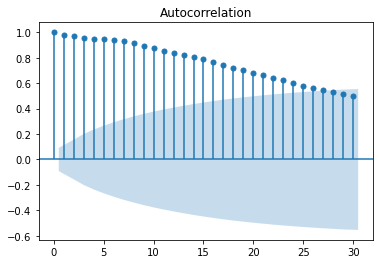

newCases - Partial Autocorrelation


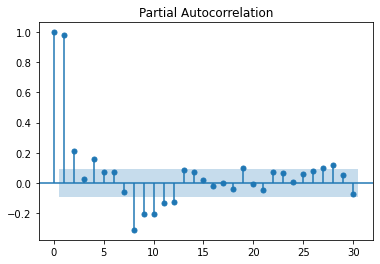

In [8]:
import statsmodels.api as sm
print('newCases - Autocorrelation')
_ = sm.graphics.tsa.plot_acf(df['newCases'], lags=30)
plt.show()
print('newCases - Partial Autocorrelation')
_ = sm.graphics.tsa.plot_pacf(df['newCases'], lags=30)
plt.show()

<h4>Findings</h4>
1. From the histogram and box plot figures above, it is clear that this is a skewed (right) distribution which looks far from a normal distribution. Presence of a lot of outliers as well based on the dataset acquired.<br/>
2. There was scope of preprocessing the data in order to address the above issue, e.g., one could have removed the initial data samples which were 0 (undersampling). We did not apply this technique here though.<br/>
3. The stationary time-series properties are not met. The various classical time-series algorithms which are dependent on this assumption may not be applicable?<br/>
4. From the autocorrelation and partial autocorrelation figures, one day time-lagged feature seems to capture the necessary information. Multiple lagged features may not be effective to be used in conjunction with this feature (looking at the figures - collinearity).<br/>
5. We will apply a supervised machine learning (ML) regression algorithm (support vector regression (SVR)) which is known to be robust against outliers unlike the various Linear regression variants.

<h3>5. Modelling</h3>

<h4>Simple Model: Return the previous day's count as the newCases</h4>

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

# separate the train and test sets
train_size = int(df.shape[0] * 0.8)
train, test = df[:train_size], df[train_size:]

# rolling training set, after considering each testing sample
# make them part of the training....
cur_index = train_size -1
pred = list()
for i in range(test.shape[0]):
    # just give the previous one as the forecast
    pred.append(train.iloc[cur_index]['newCases'])
    train = train.append(test.iloc[i], ignore_index=True)
    cur_index += 1

In [10]:
rmse_test = sqrt(mean_squared_error(test['newCases'], pred))
mae_test = mean_absolute_error(test['newCases'], pred)
rscore_test = r2_score(test['newCases'], pred)
print('TESTING SET PERFORMANCE\nRoot Mean Squared Error: {}\nMean Absolute Error: {}\nR2 Score: {}'.format(rmse_test,mae_test,rscore_test))

TESTING SET PERFORMANCE
Root Mean Squared Error: 3258.256210399774
Mean Absolute Error: 1909.7065217391305
R2 Score: 0.9558082831555121


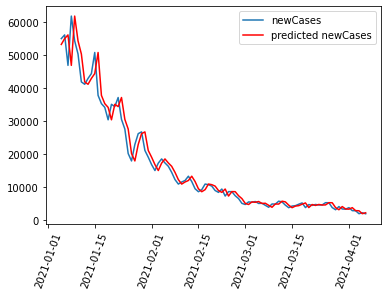

In [11]:
plt.plot(test.index, test['newCases'], label='newCases')
plt.plot(test.index, pred, color='red', label='predicted newCases')
plt.xticks(rotation=70)
plt.legend()
plt.show()

<h4>SVR: Support Vector Regression</h4>

In [12]:
# creating a new 'target' column: lagging newCases by 1 time-unit
df['TARGET'] = df['newCases'].shift(-1)
df = df.dropna()
df.tail()

,newCases,TARGET
date,,
2021-04-01,3784,2881.0
2021-04-02,2881,2847.0
2021-04-03,2847,1954.0
2021-04-04,1954,2236.0
2021-04-05,2236,1937.0


<AxesSubplot:title={'center':"TARGET's correlation with features"}>

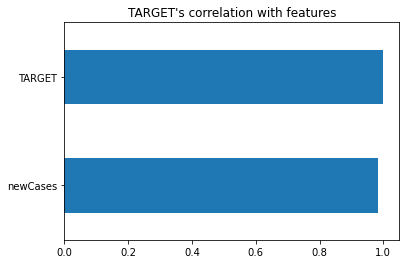

In [13]:
# show the corration of 'TARGET' variable with respect to other features
df.corrwith(df['TARGET']).plot(kind='barh', title="TARGET's correlation with features")

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# separating predictor and response variables...
X = df.drop(['TARGET'], axis=1)
y = df['TARGET']
# separating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [15]:
param_grid=[{'svr__kernel': ['linear', 'rbf']},
           {'svr__C': [x for x in range(1, 15000, 100)]},
           {'svr__gamma': [0.001, 0.01, 0.1, 1]},
           {'svr__max_iter': [10000]}]

pipe = make_pipeline(StandardScaler(), SVR())
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=10, refit=True)
grid = grid.fit(X_train, y_train)
print(grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR(C=14801))])


<h3>5. Evaluation, Inference and Saving the Model</h3>
<h4>Evaluation</h4>

In [16]:
# computing adjusted r2 score
# arguments: K = dimension of the features used
# N = no of samples
# r2_score: r2 score
def adj_r2_score(r2score, n, k):
    return (1 - ((1 - r2score) * (n-1) / (n-k-1)))

y_pred = grid.predict(X_train)
rmse_train = sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2score_train = r2_score(y_train, y_pred)
adjr2score_train = adj_r2_score(r2score_train, X_train.shape[0], X_train.shape[1])

print('TRAINING SET PERFORMANCE\nRoot Mean Squared Error: {}\nMean Absolute Error: {}\nR2 Score: {}\nAdjusted R2 Score: {}'.format(rmse_train, mae_train, r2score_train, adjr2score_train))

TRAINING SET PERFORMANCE
Root Mean Squared Error: 2177.800419022156
Mean Absolute Error: 1045.8946903855897
R2 Score: 0.9678772243949918
Adjusted R2 Score: 0.9677892167905945


In [17]:
y_pred = grid.predict(X_test)
rmse_test = sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2score_test = r2_score(y_test, y_pred)
adjr2score_test = adj_r2_score(r2score_test, X_test.shape[0], X_test.shape[1])

print('TESTING SET PERFORMANCE\nRoot Mean Squared Error: {}\nMean Absolute Error: {}\nR2 Score: {}\nAdjusted R2 Score: {}'.format(rmse_test, mae_test, r2score_test, adjr2score_test))

TESTING SET PERFORMANCE
Root Mean Squared Error: 2264.702165237395
Mean Absolute Error: 1013.8863720066075
R2 Score: 0.9590040522765712
Adjusted R2 Score: 0.9585485417463109


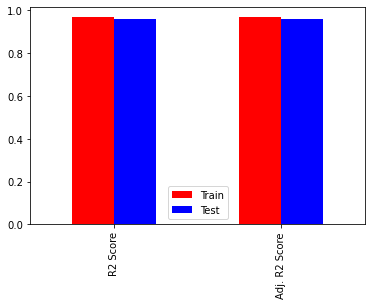

In [18]:
xticks = ['R2 Score', 'Adj. R2 Score']
Scores = np.array([[r2score_train,r2score_test], [adjr2score_train, adjr2score_test]])
colors = ['red','blue']
names = ["Train", "Test"]
fig, ax = plt.subplots()
pd.DataFrame(Scores, index=xticks, columns=names).plot.bar(color=colors, ax=ax)
plt.show()

<h4>Inference</h4>

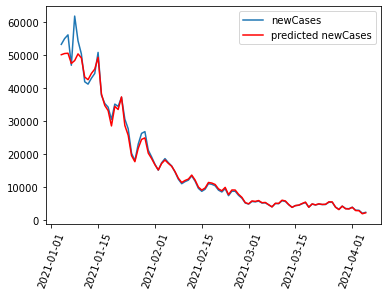

In [19]:
# this part is just to draw for the last 20% data prediction with the already fitted model
test = X[int(X.shape[0] * 0.8):]
# grid is already trained model
pred = grid.predict(test)

plt.plot(test.index, test['newCases'], label='newCases')
plt.plot(test.index, pred, color='red', label='predicted newCases')
plt.xticks(rotation=70)
plt.legend()
plt.show()

In [20]:
from datetime import datetime
from datetime import timedelta

# predict tomorrow's figure based on today's number
print("Tomorrow's ({}) prediction of newCases: {}".format(datetime.now().date()+timedelta(days=1),int(grid.predict(df.iloc[-1]['TARGET'].reshape(1, -1))[0])))
#print(datetime.now()+timedelta(days=1))

Tomorrow's (2021-04-08) prediction of newCases: 1783


<h4>Saving the Model</h4>

In [21]:
import pickle

# save the Modle to file in the current working directory
Pkl_Filename = "model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(grid, file)

In [22]:
# find out the scikit-learn's version that was used to create the module
# may be required for dependency if you are installing it as a Web Service inside a Docker container
!conda list scikit-learn

# packages in environment at D:\Anaconda:
#
# Name                    Version                   Build  Channel
scikit-learn              0.23.2           py37h47e9c7a_0  
